In [2]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

In [87]:
df = pd.read_csv('../data/nba.csv')
df.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Travis Knight,LAL,22.0,213.36,106.59412,Connecticut,USA,1996,1,...,4.8,4.5,0.5,6.2,0.127,0.182,0.142,0.536,0.052,1996-97
1,1,Matt Fish,MIA,27.0,210.82,106.59412,North Carolina-Wilmington,USA,1992,2,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1996-97
2,2,Matt Bullard,HOU,30.0,208.28,106.59412,Iowa,USA,Undrafted,Undrafted,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1996-97
3,3,Marty Conlon,BOS,29.0,210.82,111.13004,Providence,USA,Undrafted,Undrafted,...,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1996-97
4,4,Martin Muursepp,DAL,22.0,205.74,106.59412,None,USA,1996,1,...,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1996-97


In [88]:
df.drop('Unnamed: 0', axis=1, inplace=True)

# EDA

In [63]:
def plot_team_player_stat(team_abbv, season):
    team = df[df['season'] == season]
    team = team[team['team_abbreviation'] == team_abbv]
    plot = plt.subplots(figsize=(10, 6))
    plot = sns.barplot(x='pts', y='player_name', data=team, order=team.sort_values('pts').player_name, color='indianred',
                      label='Points')
    plot = sns.barplot(x='ast', y='player_name', data=team, order=team.sort_values('pts').player_name, color='dimgrey',
                      label='Assists')
    plot.set(xlabel='Stats', ylabel='Players')
    plot.set_xlim(0, 30)
    plot.set_xticks(range(0, 30, 2))
    plt.legend(frameon=False)
    plt.show()

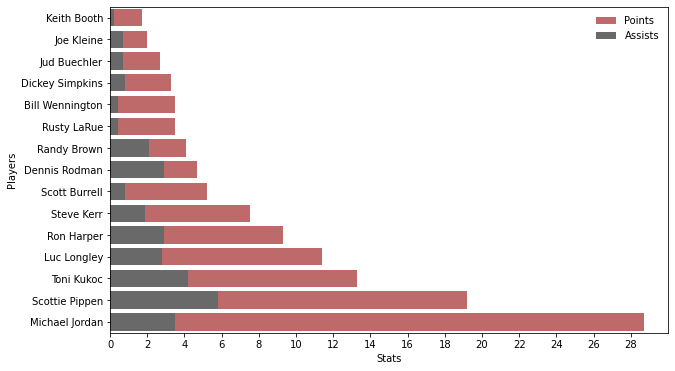

In [64]:
plot_team_player_stat('CHI', '1997-98')

In [65]:
def show_top_n_by_seaseon_and_stat(season, stat, n):
    players = df[df.season == season]
    players = players.sort_values(stat, ascending=False)
    players = players[:n]
    plot = sns.barplot(x=stat, y='player_name', data=players, order=players.sort_values(stat).player_name, palette='Pastel1')
    plot.set_ylabel('Players')
    plot.set_xlim(0, int(np.max(players[stat])))
    plot.set_xticks(range(0, int(np.max(players[stat]))+1,2))
    plt.show()

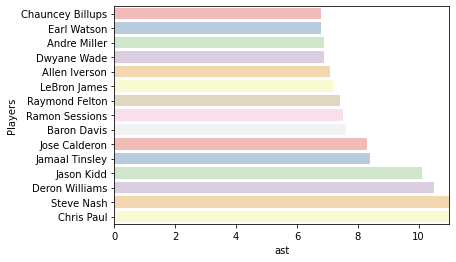

In [66]:
show_top_n_by_seaseon_and_stat('2007-08', 'ast', 15)

In [67]:
def plot_pts_reb_ast(team):
    fig, (ax, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)
    
    scatter = ax.scatter(df.age[df.team_abbreviation == team],
                        df.pts[df.team_abbreviation == team],
                        c='indianred')
    ax.axhline(df.pts.mean(), linestyle='--', color='green')
    ax.set(ylabel='Points', title='PPG')
    
    scatter = ax1.scatter(df.age[df.team_abbreviation == team],
                         df.reb[df.team_abbreviation == team],
                         c='limegreen')
    ax1.axhline(df.reb.mean(), linestyle='--', color='red')
    ax1.set(ylabel='Rebounds', title='RPG')
    
    scatter = ax2.scatter(df.age[df.team_abbreviation == team],
                         df.ast[df.team_abbreviation == team],
                         c='navy')
    ax2.axhline(df.ast.mean(), linestyle='--', color='darkorange')
    ax2.set(ylabel='Assist', title='APG')
    
    plt.suptitle(f'{team} stats through the years')

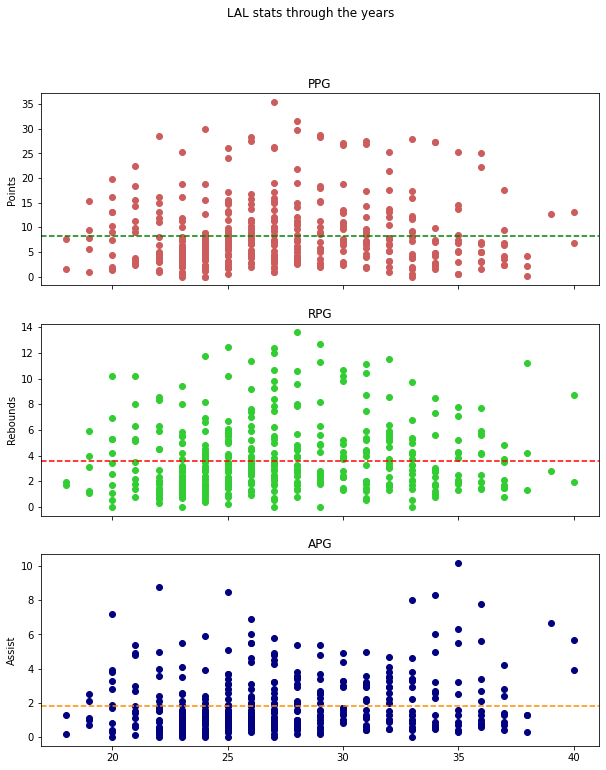

In [68]:
plot_pts_reb_ast('LAL')

# Preprocessing Data

In [69]:
def preprocess_data(df):
        
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label] = content.fillna(content.median())
    
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [70]:
df_tmp = preprocess_data(df)
df_tmp.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,2170,15,22.0,213.36,106.59412,62,73,21,2,29,...,4.8,4.5,0.5,6.2,0.127,0.182,0.142,0.536,0.052,1
1,1545,17,27.0,210.82,106.59412,190,73,17,3,53,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1
2,1542,12,30.0,208.28,106.59412,115,73,46,9,76,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1
3,1532,3,29.0,210.82,111.13004,221,73,46,9,76,...,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1
4,1531,8,22.0,205.74,106.59412,185,73,21,2,25,...,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1


# Splitting data

In [89]:
df_1996_2010 = df[df.season < '2010-11']
df_train = preprocess_data(df_1996_2010)

In [105]:
df_train

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,1272,14,22.0,213.36,106.594120,44,52,20,1,28,...,4.8,4.5,0.5,6.2,0.127,0.182,0.142,0.536,0.052,1
1,889,16,27.0,210.82,106.594120,147,52,16,2,52,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1
2,887,11,30.0,208.28,106.594120,86,52,34,8,74,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1
3,881,2,29.0,210.82,111.130040,175,52,34,8,74,...,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1
4,880,7,22.0,205.74,106.594120,143,52,20,1,24,...,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6221,437,13,21.0,190.50,100.697424,84,52,32,1,67,...,16.9,2.6,3.0,-4.6,0.013,0.070,0.214,0.571,0.135,14
6222,435,20,27.0,208.28,115.665960,44,52,28,1,18,...,10.4,9.0,0.7,-2.9,0.120,0.245,0.171,0.547,0.035,14
6223,433,25,31.0,205.74,115.212368,54,52,23,1,1,...,13.1,6.1,1.4,-2.8,0.091,0.146,0.216,0.518,0.078,14
6224,474,29,24.0,198.12,86.182480,101,52,34,8,74,...,5.0,1.1,0.8,0.5,0.019,0.081,0.197,0.553,0.104,14


In [90]:
df_1996_2010

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,1272,14,22.0,213.36,106.594120,44,52,20,1,28,...,4.8,4.5,0.5,6.2,0.127,0.182,0.142,0.536,0.052,1
1,889,16,27.0,210.82,106.594120,147,52,16,2,52,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1
2,887,11,30.0,208.28,106.594120,86,52,34,8,74,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1
3,881,2,29.0,210.82,111.130040,175,52,34,8,74,...,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1
4,880,7,22.0,205.74,106.594120,143,52,20,1,24,...,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6221,437,13,21.0,190.50,100.697424,84,52,32,1,67,...,16.9,2.6,3.0,-4.6,0.013,0.070,0.214,0.571,0.135,14
6222,435,20,27.0,208.28,115.665960,44,52,28,1,18,...,10.4,9.0,0.7,-2.9,0.120,0.245,0.171,0.547,0.035,14
6223,433,25,31.0,205.74,115.212368,54,52,23,1,1,...,13.1,6.1,1.4,-2.8,0.091,0.146,0.216,0.518,0.078,14
6224,474,29,24.0,198.12,86.182480,101,52,34,8,74,...,5.0,1.1,0.8,0.5,0.019,0.081,0.197,0.553,0.104,14


In [91]:
df_2010_2020 = df['2010-11'<= df.season]
df_2010_2020 = df_2010_2020[df_2010_2020.season <= '2019-2020']
df_valid = preprocess_data(df_2010_2020)

In [106]:
df_valid

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
6226,276,15,23.0,205.74,106.594120,84,66,18,2,21,...,9.1,4.3,0.7,2.0,0.082,0.167,0.216,0.534,0.056,1
6227,2,12,24.0,187.96,82.100152,44,66,19,3,49,...,6.5,1.4,2.2,1.6,0.022,0.083,0.227,0.454,0.233,1
6228,880,32,32.0,195.58,99.790240,192,66,30,5,63,...,6.3,2.1,0.6,-7.8,0.036,0.080,0.140,0.513,0.046,1
6229,879,18,27.0,195.58,91.625584,109,66,16,2,22,...,3.8,0.5,0.3,-12.9,0.000,0.095,0.216,0.682,0.063,1
6230,873,4,30.0,198.12,96.161504,137,66,30,5,63,...,4.4,1.3,0.4,-6.4,0.023,0.124,0.194,0.530,0.068,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11155,860,6,22.0,208.28,112.944408,52,66,29,5,63,...,0.0,2.0,0.0,57.1,0.000,0.500,0.000,0.000,0.000,10
11156,859,15,25.0,198.12,91.171992,128,52,30,5,63,...,3.9,1.7,1.0,-2.6,0.028,0.115,0.168,0.514,0.127,10
11157,858,14,30.0,203.20,111.130040,84,66,21,2,6,...,9.7,3.8,1.3,-5.8,0.033,0.144,0.202,0.565,0.100,10
11158,869,8,30.0,210.82,115.212368,52,66,23,2,16,...,7.2,5.2,2.5,-1.0,0.087,0.195,0.173,0.613,0.210,10


In [94]:
df_2010_2020

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
6226,276,15,23.0,205.74,106.594120,84,66,18,2,21,...,9.1,4.3,0.7,2.0,0.082,0.167,0.216,0.534,0.056,1
6227,2,12,24.0,187.96,82.100152,44,66,19,3,49,...,6.5,1.4,2.2,1.6,0.022,0.083,0.227,0.454,0.233,1
6228,880,32,32.0,195.58,99.790240,192,66,30,5,63,...,6.3,2.1,0.6,-7.8,0.036,0.080,0.140,0.513,0.046,1
6229,879,18,27.0,195.58,91.625584,109,66,16,2,22,...,3.8,0.5,0.3,-12.9,0.000,0.095,0.216,0.682,0.063,1
6230,873,4,30.0,198.12,96.161504,137,66,30,5,63,...,4.4,1.3,0.4,-6.4,0.023,0.124,0.194,0.530,0.068,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11155,860,6,22.0,208.28,112.944408,52,66,29,5,63,...,0.0,2.0,0.0,57.1,0.000,0.500,0.000,0.000,0.000,10
11156,859,15,25.0,198.12,91.171992,128,52,30,5,63,...,3.9,1.7,1.0,-2.6,0.028,0.115,0.168,0.514,0.127,10
11157,858,14,30.0,203.20,111.130040,84,66,21,2,6,...,9.7,3.8,1.3,-5.8,0.033,0.144,0.202,0.565,0.100,10
11158,869,8,30.0,210.82,115.212368,52,66,23,2,16,...,7.2,5.2,2.5,-1.0,0.087,0.195,0.173,0.613,0.210,10


In [92]:
df_2020_2021 = df[df.season == '2020-21']
df_test = preprocess_data(df_2020_2021)

In [99]:
df_test.columns

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object')

In [97]:
X_train, y_train = df_train.drop('reb', axis=1), df_train['reb']
X_val, y_val = df_valid.drop('reb', axis=1), df_valid['reb']
X_test, y_test = df_test.drop('reb', axis=1), df_test['reb']

# Modelling

In [69]:
models = {
    'RandomForestRegressor':RandomForestRegressor(),
    'Ridge':Ridge(),
    'SVR':SVR()
}

base_scores = {}


In [70]:
for name, model in models.items():
    model.fit(X_train, y_train)
    base_scores[name] = model.score(X_train, y_train)

In [71]:
base_scores

{'RandomForestRegressor': 0.9950940688129496,
 'Ridge': 0.813777513947514,
 'SVR': 0.2996649561887017}

In [107]:
model = RandomForestRegressor(n_jobs=-1, random_state=23).fit(X_train, y_train)

# Building an evaluation function

In [110]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error

def rmsle(y_true, y_preds):
    return np.sqrt(mean_squared_log_error(y_true, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_val)
    
    scores = {
        'Training MAE':mean_absolute_error(y_train, train_preds),
        'Valid MAE':mean_absolute_error(y_val, valid_preds),
        'Training RMSLE':rmsle(y_train, train_preds),
        'Valid RMSLE':rmsle(y_val, valid_preds),
        'Training R2':r2_score(y_train, train_preds),
        'Valid R2':r2_score(y_val, valid_preds)
    }
    
    return scores

In [111]:
show_scores(model)

{'Training MAE': 0.11696916158046909,
 'Valid MAE': 0.3632756384272395,
 'Training RMSLE': 0.0379277165398576,
 'Valid RMSLE': 0.10882067088211467,
 'Training R2': 0.9950456970938112,
 'Valid R2': 0.9518914369842597}

# Hyperparameter tuning

In [112]:
rf_grid = {
    'n_estimators':np.arange(100, 1000, 100),
    'max_depth':[None, 3, 5],
    'max_features':['auto', 'sqrt', 'log2'],
    'min_samples_split':np.arange(2, 20, 2),
    'min_samples_leaf':np.arange(1, 20, 2)
}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),
                             param_distributions=rf_grid,
                             n_iter=20,
                             cv=5,
                             verbose=True,
                             random_state=23)

%time rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 4min 25s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=23, verbose=True)

In [113]:
show_scores(rs_model), show_scores(model)

({'Training MAE': 0.16522742207318428,
  'Valid MAE': 0.3652627171437805,
  'Training RMSLE': 0.05324671714961425,
  'Valid RMSLE': 0.10954189460933425,
  'Training R2': 0.9894908957360183,
  'Valid R2': 0.9512238759114365},
 {'Training MAE': 0.1169691615804691,
  'Valid MAE': 0.3632756384272395,
  'Training RMSLE': 0.0379277165398576,
  'Valid RMSLE': 0.10882067088211467,
  'Training R2': 0.9950456970938112,
  'Valid R2': 0.9518914369842597})

In [114]:
rs_model.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None}

In [115]:
ideal_model = RandomForestRegressor(n_estimators=400,
                                   min_samples_split=10,
                                   min_samples_leaf=1,
                                   max_depth=None,
                                   max_features='auto')
ideal_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=10, n_estimators=400)

# Making predictions on test data

In [116]:
X_test.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
11160,536,13,28.0,182.88,80.739376,43,41,19,4,61,10,5.6,2.2,-0.4,0.034,0.095,0.193,0.459,0.229,1
11161,540,19,20.0,200.66,128.820128,31,41,17,2,1,61,27.0,3.7,2.1,0.081,0.131,0.287,0.649,0.188,1
11162,539,8,20.0,205.74,108.862080,3,41,18,2,15,42,3.2,0.2,-10.5,0.034,0.129,0.126,0.615,0.037,1
11163,538,5,26.0,195.58,90.718400,116,41,12,2,5,58,27.4,4.9,-0.8,0.018,0.121,0.302,0.634,0.225,1
11164,537,28,26.0,205.74,97.522280,36,25,19,4,61,50,4.4,0.8,-2.7,0.046,0.171,0.121,0.565,0.079,1


In [117]:
test_preds = ideal_model.predict(X_test)

In [118]:
df = pd.read_csv('../data/nba.csv')
df_2020_2021 = df[df.season == '2020-21']
df_preds = pd.DataFrame()
df_preds['player_name'] = df_2020_2021['player_name']
df_preds['reb'] = test_preds
df_preds

,player_name,reb
11160,Yogi Ferrell,1.959356
11161,Zion Williamson,6.664896
11162,Zeke Nnaji,1.784232
11163,Zach LaVine,4.773580
11164,Yuta Watanabe,3.712719
...,...,...
11695,Matthew Dellavedova,1.377247
11696,Maurice Harkless,2.256180
11697,Max Strus,1.384432
11698,Marcus Morris Sr.,4.582029


In [126]:
df_preds.to_csv("../prediction\'s/2020-21-RPG-Prediction.csv")

# Feature Importance

In [102]:
ideal_model.feature_importances_

array([1.48745539e-03, 1.23319469e-03, 1.10543721e-03, 8.48968757e-04,
       1.40749698e-03, 1.29856607e-03, 2.98384436e-04, 1.24580890e-03,
       1.35557989e-04, 1.18008286e-03, 3.08980326e-03, 4.31264192e-01,
       4.11300638e-03, 1.49834918e-03, 2.90348712e-02, 4.71177083e-01,
       4.30990120e-02, 3.94423354e-03, 1.04304907e-03, 1.49544696e-03])

In [110]:
def plot_feature_importance(col, importance, n=20):
    df = pd.DataFrame({'features':col,
                 'feature_importance':importance}).sort_values('feature_importance', ascending=False)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df['features'][:20], df['feature_importance'][:20], color='hotpink')
    ax.invert_yaxis()
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_title('Feature Importances')

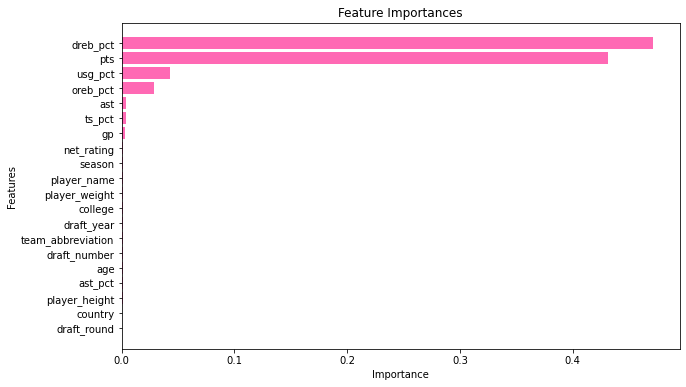

In [111]:
plot_feature_importance(X_train.columns, ideal_model.feature_importances_)